## Understanding backpropogation

In this notebook, we understand backpropogation using elementary arithmetic operations following [Andrej Karpathy's tutorial](https://www.youtube.com/watch?v=VMj-3S1tku0). We recommend visiting [micrograd](https://github.com/karpathy/micrograd) on github.

We start with a few basic imports:

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

We now define the Value class which forms the heart of micrograd:

In [9]:
class Value:
    """ stores a single scalar value and its gradient """
    def __init__(self, data, _children=(), _op='', label=''): #__init__(object, data, attributes)
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out  
      
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only supporting int/float powers for now
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out    
    
    def __truediv__(self, other): # self / other
        return self*other**-1   
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rmul__(self, other): # other * self
        return self * other
    def __radd__(self, other): # other + self
        return self + other
    def __rsub__(self, other): # other - self
        return other + (-self)
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    #pow, truediv
    
    def backward(self):
        #topological sort 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        # implements in order: o._backward(), nn._backward(), x1w1x2w2._backward(), x2w2._backward(), x1w1._backward()


Basically, the Value class defines python's elementary arithmetic operations (like add, multiply, divide) for a computational graph represented as a tree data structure: the root node of the tree signifies the neural net output, and leaf nodes signify the input data vector along with first-layer weights. In addition, it includes rules for local gradient updates in $\texttt{\_backward()}$ and a full-graph gradient update in $\texttt{backward()}$. The full-graph gradient update combines $\texttt{\_backward()}$ with a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting) approach to traversing the graph from output to input nodes. The main non-elementary differentiable operation it contains is [tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions), which is to be used as the nonlinear activation function at each node.

We now include a graphviz code like Andrej does, that is capable of visualizing such a computational graph diagrammatically

In [11]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

The code above can basically draw the entire graph, and indicate label, data, \& gradient information at each node. The gradient at each node $j$ (as computed in value class) is the partial derivative of its weight $w_j$ w.r.t. the output loss function $L(o)$, so that's $\frac{\partial w_j}{\partial L}$. As such the NN output is just $o(\textbf{x}_{in},\textbf{w})$; the loss function is an additional step computing a function of output and supervised output labels of training data, as a simple example $\lVert o(\textbf{x}_{in},\textbf{w}) - l \rVert_{2}$, where weight vector $\textbf{w}$ is known to produce a scalar output $l$, and the 2-norm (mean squared loss) is only really sensible in the limit of multiple outputs (so that $\textbf{o}$ and $\textbf{l}$ become vectors)

Just out of curiosity, the hyperbolic tangent is plotted to visualize its nonlinearity:

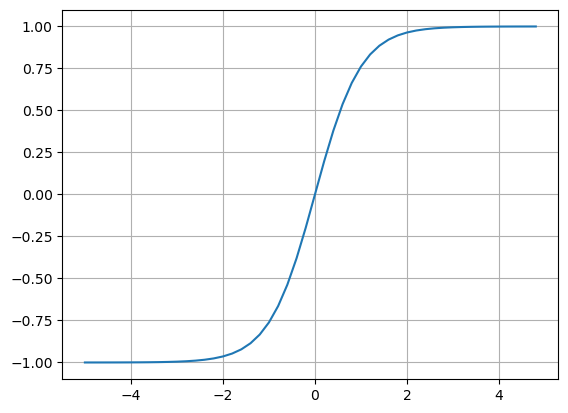

In [8]:
plt.plot( np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)) ); plt.grid()

In what follows, a simple two-input neuron is initialized via the value class:

In [9]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.88137358,label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'; print(x1w1)
x2w2 = x2*w2; x2w2.label = 'x2*w2'; print(x2w2)
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'; print(x1w1x2w2)
nn = x1w1x2w2 + b; nn.label = 'nn'; print(nn)
o = nn.tanh(); o.label = 'o'; print(o)

Value(data=-6.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=0.88137358)
Value(data=0.707106777676776)


and then the gradients are backpropogated using the $\texttt{backward()}$ function in value class, and visualized using the $\texttt{draw\_dot()}$ function defined in the graphviz section earlier:

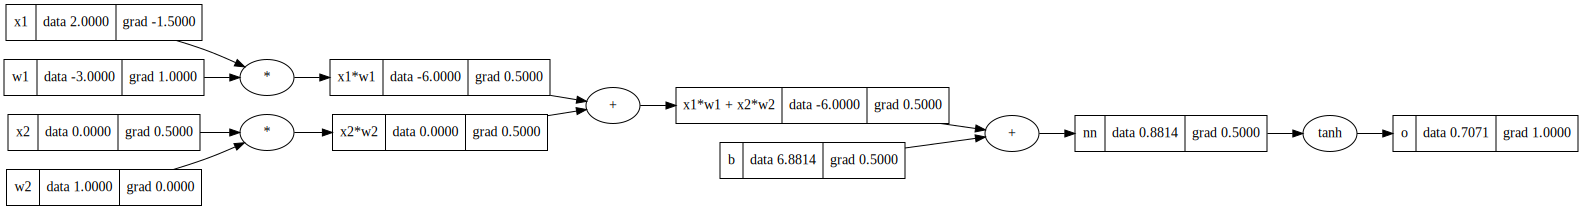

In [10]:
o.backward()
draw_dot(o)

Now, just as an extra exercise in object oriented programming, the tanh function is further broken down as $\tanh(x) = \frac{e^{2x} + 1}{e^{2x} - 1}$ and we implement it as a composite function of exponentiation, addition (subtraction), division. Division in the value class is implemented more generally as a composite of multiplication and monomials: $\frac{a}{b} = a*b^{-1}$, so implement $\texttt{pow()}$ in value class so that we can more generally produce monomials $x^n$ of arbitrary degree in our arithmetic system.

Once the above steps are implemented in the value class, we can now produce a longer computational graph and verify that we still get the same gradients:

Value(data=-6.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=0.88137358)
Value(data=5.828427042920401)


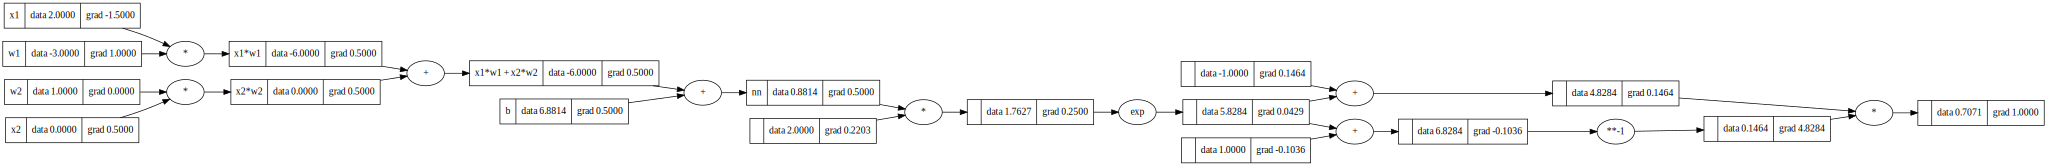

In [13]:
#after implementing pow, truediv, exp
# inputs x1, x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1, w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# neuron bias
b = Value(6.88137358,label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'; print(x1w1)
x2w2 = x2 * w2; x2w2.label = 'x2*w2'; print(x2w2)
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'; print(x1w1x2w2)
nn = x1w1x2w2 + b; nn.label = 'nn'; print(nn)
ee = (2 * nn).exp(); print(ee)
o = (ee - 1) / (ee + 1)
o.backward()
draw_dot(o)

We now shift focus to being able to achieve the same with Pytorch: the most popular deep learning library. In the process, we can verify the functional equivalence of micrograd's and Pytorch's $\texttt{backward()}$ functions:

In [14]:
# single two-param neuron backprop in pytorch

import torch
x1 = torch.Tensor([2.0]).double()   ;   x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ;   x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ;   w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ;   w2.requires_grad = True
b = torch.Tensor([6.8813735]).double() ;   b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


That's it from me! I'm skipping the part where Andrej discusses the $\texttt{nn.py}$ classes, as that's primarily linguistic abstractions. The core mathematics is automatic differentiation on computational graphs. Backpropogation is simply a special case where such an autograd engine is applied to an "ansatz" of nonlinear functions we call neural networks. Have a wonderful day!

Roughwork

In [16]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

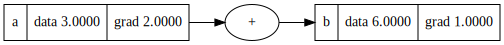

In [234]:
a = Value(3.0, label='a')
b=a+a; b.label = 'b'
b.backward()
draw_dot(b)

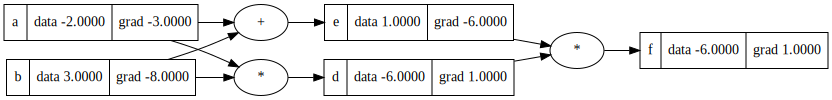

In [235]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b   ;   d.label = 'd'
e = a + b   ;   e.label = 'e'
f = d * e   ;   f.label = 'f'
f.backward()
draw_dot(f)

In [242]:
a = Value(2.0)
2 * a


Value(data=4.0)